In [1]:
!pip3 install facenet-pytorch

     |████████████████████████████████| 1.9MB 9.1MB/s 


In [2]:
import torch
from torch.utils.data import DataLoader, Dataset
import torchvision
from torchvision import transforms
import numpy as np
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from PIL import Image
import pandas as pd
from facenet_pytorch import  fixed_image_standardization

In [3]:
import torch
from torch import nn
from torch.nn import functional as F
# import requests
# from requests.adapters import HTTPAdapter
# import os


class BasicConv2d(nn.Module):

    def __init__(self, in_planes, out_planes, kernel_size, stride, padding=0):
        super().__init__()
        self.conv = nn.Conv2d(
            in_planes, out_planes,
            kernel_size=kernel_size, stride=stride,
            padding=padding, bias=False
        ) # verify bias false
        self.bn = nn.BatchNorm2d(
            out_planes,
            eps=0.001, # value found in tensorflow
            momentum=0.1, # default pytorch value
            affine=True
        )
        self.relu = nn.ReLU(inplace=False)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x


class Block35(nn.Module):

    def __init__(self, scale=1.0):
        super().__init__()

        self.scale = scale

        self.branch0 = BasicConv2d(256, 32, kernel_size=1, stride=1)

        self.branch1 = nn.Sequential(
            BasicConv2d(256, 32, kernel_size=1, stride=1),
            BasicConv2d(32, 32, kernel_size=3, stride=1, padding=1)
        )

        self.branch2 = nn.Sequential(
            BasicConv2d(256, 32, kernel_size=1, stride=1),
            BasicConv2d(32, 32, kernel_size=3, stride=1, padding=1),
            BasicConv2d(32, 32, kernel_size=3, stride=1, padding=1)
        )

        self.conv2d = nn.Conv2d(96, 256, kernel_size=1, stride=1)
        self.relu = nn.ReLU(inplace=False)

    def forward(self, x):
        x0 = self.branch0(x)
        x1 = self.branch1(x)
        x2 = self.branch2(x)
        out = torch.cat((x0, x1, x2), 1)
        out = self.conv2d(out)
        out = out * self.scale + x
        out = self.relu(out)
        return out


class Block17(nn.Module):

    def __init__(self, scale=1.0):
        super().__init__()

        self.scale = scale

        self.branch0 = BasicConv2d(896, 128, kernel_size=1, stride=1)

        self.branch1 = nn.Sequential(
            BasicConv2d(896, 128, kernel_size=1, stride=1),
            BasicConv2d(128, 128, kernel_size=(1,7), stride=1, padding=(0,3)),
            BasicConv2d(128, 128, kernel_size=(7,1), stride=1, padding=(3,0))
        )

        self.conv2d = nn.Conv2d(256, 896, kernel_size=1, stride=1)
        self.relu = nn.ReLU(inplace=False)

    def forward(self, x):
        x0 = self.branch0(x)
        x1 = self.branch1(x)
        out = torch.cat((x0, x1), 1)
        out = self.conv2d(out)
        out = out * self.scale + x
        out = self.relu(out)
        return out


class Block8(nn.Module):

    def __init__(self, scale=1.0, noReLU=False):
        super().__init__()

        self.scale = scale
        self.noReLU = noReLU

        self.branch0 = BasicConv2d(1792, 192, kernel_size=1, stride=1)

        self.branch1 = nn.Sequential(
            BasicConv2d(1792, 192, kernel_size=1, stride=1),
            BasicConv2d(192, 192, kernel_size=(1,3), stride=1, padding=(0,1)),
            BasicConv2d(192, 192, kernel_size=(3,1), stride=1, padding=(1,0))
        )

        self.conv2d = nn.Conv2d(384, 1792, kernel_size=1, stride=1)
        if not self.noReLU:
            self.relu = nn.ReLU(inplace=False)

    def forward(self, x):
        x0 = self.branch0(x)
        x1 = self.branch1(x)
        out = torch.cat((x0, x1), 1)
        out = self.conv2d(out)
        out = out * self.scale + x
        if not self.noReLU:
            out = self.relu(out)
        return out


class Mixed_6a(nn.Module):

    def __init__(self):
        super().__init__()

        self.branch0 = BasicConv2d(256, 384, kernel_size=3, stride=2)

        self.branch1 = nn.Sequential(
            BasicConv2d(256, 192, kernel_size=1, stride=1),
            BasicConv2d(192, 192, kernel_size=3, stride=1, padding=1),
            BasicConv2d(192, 256, kernel_size=3, stride=2)
        )

        self.branch2 = nn.MaxPool2d(3, stride=2)

    def forward(self, x):
        x0 = self.branch0(x)
        x1 = self.branch1(x)
        x2 = self.branch2(x)
        out = torch.cat((x0, x1, x2), 1)
        return out


class Mixed_7a(nn.Module):

    def __init__(self):
        super().__init__()

        self.branch0 = nn.Sequential(
            BasicConv2d(896, 256, kernel_size=1, stride=1),
            BasicConv2d(256, 384, kernel_size=3, stride=2)
        )

        self.branch1 = nn.Sequential(
            BasicConv2d(896, 256, kernel_size=1, stride=1),
            BasicConv2d(256, 256, kernel_size=3, stride=2)
        )

        self.branch2 = nn.Sequential(
            BasicConv2d(896, 256, kernel_size=1, stride=1),
            BasicConv2d(256, 256, kernel_size=3, stride=1, padding=1),
            BasicConv2d(256, 256, kernel_size=3, stride=2)
        )

        self.branch3 = nn.MaxPool2d(3, stride=2)

    def forward(self, x):
        x0 = self.branch0(x)
        x1 = self.branch1(x)
        x2 = self.branch2(x)
        x3 = self.branch3(x)
        out = torch.cat((x0, x1, x2, x3), 1)
        return out


class InceptionResnetV1(nn.Module):
    """Inception Resnet V1 model with optional loading of pretrained weights.
    Model parameters can be loaded based on pretraining on the VGGFace2 or CASIA-Webface
    datasets. Pretrained state_dicts are automatically downloaded on model instantiation if
    requested and cached in the torch cache. Subsequent instantiations use the cache rather than
    redownloading.
    Keyword Arguments:
        pretrained {str} -- Optional pretraining dataset. Either 'vggface2' or 'casia-webface'.
            (default: {None})
        classify {bool} -- Whether the model should output classification probabilities or feature
            embeddings. (default: {False})
        num_classes {int} -- Number of output classes. If 'pretrained' is set and num_classes not
            equal to that used for the pretrained model, the final linear layer will be randomly
            initialized. (default: {None})
        dropout_prob {float} -- Dropout probability. (default: {0.6})
    """
    def __init__(self, pretrained=None, classify=False, num_classes=None, dropout_prob=0.6, device=None):
        super().__init__()

        # Set simple attributes
        self.pretrained = pretrained
        self.classify = classify
        self.num_classes = num_classes

        if pretrained == 'vggface2':
            tmp_classes = 8631
        elif pretrained == 'casia-webface':
            tmp_classes = 10575
        elif pretrained is None and self.num_classes is None:
            raise Exception('At least one of "pretrained" or "num_classes" must be specified')
        else:
            tmp_classes = self.num_classes


        # Define layers
        self.conv2d_1a = BasicConv2d(3, 32, kernel_size=3, stride=2)
        self.conv2d_2a = BasicConv2d(32, 32, kernel_size=3, stride=1)
        self.conv2d_2b = BasicConv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.maxpool_3a = nn.MaxPool2d(3, stride=2)
        self.conv2d_3b = BasicConv2d(64, 80, kernel_size=1, stride=1)
        self.conv2d_4a = BasicConv2d(80, 192, kernel_size=3, stride=1)
        self.conv2d_4b = BasicConv2d(192, 256, kernel_size=3, stride=2)
        self.repeat_1 = nn.Sequential(
            Block35(scale=0.17),
            Block35(scale=0.17),
            Block35(scale=0.17),
            Block35(scale=0.17),
            Block35(scale=0.17),
        )
        self.mixed_6a = Mixed_6a()
        self.repeat_2 = nn.Sequential(
            Block17(scale=0.10),
            Block17(scale=0.10),
            Block17(scale=0.10),
            Block17(scale=0.10),
            Block17(scale=0.10),
            Block17(scale=0.10),
            Block17(scale=0.10),
            Block17(scale=0.10),
            Block17(scale=0.10),
            Block17(scale=0.10),
        )
        self.mixed_7a = Mixed_7a()
        self.repeat_3 = nn.Sequential(
            Block8(scale=0.20),
            Block8(scale=0.20),
            Block8(scale=0.20),
            Block8(scale=0.20),
            Block8(scale=0.20),
        )
        self.block8 = Block8(noReLU=True)
        self.avgpool_1a = nn.AdaptiveAvgPool2d(1)
        self.dropout = nn.Dropout(dropout_prob)
        self.last_linear = nn.Linear(1792, 512, bias=False)
        self.last_bn = nn.BatchNorm1d(512, eps=0.001, momentum=0.1, affine=True)
        self.logits = nn.Linear(512, tmp_classes)

        if pretrained is not None:
            load_weights(self, pretrained)

        if self.num_classes is not None:
            self.logits = nn.Linear(512, self.num_classes)

        self.device = torch.device('cpu')
        if device is not None:
            self.device = device
            self.to(device)

    def forward(self, x):
        """Calculate embeddings or logits given a batch of input image tensors.
        Arguments:
            x {torch.tensor} -- Batch of image tensors representing faces.
        Returns:
            torch.tensor -- Batch of embedding vectors or multinomial logits.
        """
        x = self.conv2d_1a(x)
        x = self.conv2d_2a(x)
        x = self.conv2d_2b(x)
        x = self.maxpool_3a(x)
        x = self.conv2d_3b(x)
        x = self.conv2d_4a(x)
        x = self.conv2d_4b(x)
        x = self.repeat_1(x)
        x = self.mixed_6a(x)
        x = self.repeat_2(x)
        x_mix_7 = self.mixed_7a(x)
        xr3 = self.repeat_3(x_mix_7)
        x_b8 = self.block8(xr3)
        x = self.avgpool_1a(x)
        # x = self.dropout(x)
        # x = self.last_linear(x.view(x.shape[0], -1))
        # x = self.last_bn(x)
        # if self.classify:
        #     x = self.logits(x)
        # else:
        #     x = F.normalize(x, p=2, dim=1)
        return x_mix_7, xr3, x_b8
def load_weights(mdl, name):
    """Download pretrained state_dict and load into model.
    Arguments:
        mdl {torch.nn.Module} -- Pytorch model.
        name {str} -- Name of dataset that was used to generate pretrained state_dict.
    Raises:
        ValueError: If 'pretrained' not equal to 'vggface2' or 'casia-webface'.
    """
    if name == 'vggface2':
        features_path = '/content/drive/My Drive/Colab Notebooks/vggface2 weights/20180402-114759-vggface2-features.pt'
        logits_path = '/content/drive/My Drive/Colab Notebooks/vggface2 weights/20180402-114759-vggface2-logits.pt'
    elif name == 'casia-webface':
        features_path = '/content/drive/My Drive/Colab Notebooks/casia webface weights/20180408-102900-casia-webface-features.pt'
        logits_path = '/content/drive/My Drive/Colab Notebooks/casia webface weights/20180408-102900-casia-webface-logits.pt'
    else:
        raise ValueError('Pretrained models only exist for "vggface2" and "casia-webface"')
        
    state_dict = {}
    for path in [features_path, logits_path]:
        print("LOADING PATH")
        state_dict.update(torch.load(path))
        layer = 0

    mdl.load_state_dict(state_dict)
    

In [4]:
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [5]:
%%time
zip_path = '/content/drive/My Drive/Colab Notebooks/allimgs_face2.zip'
!cp "{zip_path}" .
!unzip -q allimgs_face2.zip 
!rm allimgs_face2.zip

CPU times: user 43.9 ms, sys: 15.3 ms, total: 59.2 ms
Wall time: 12.5 s


zip_path

zip_path

8979
997


In [6]:
# # Get train and test data for classification
train_df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/train_on_cand.csv')
new_paths = []
for path, winner in zip(train_df[train_df.columns[2]].tolist(), train_df[train_df.columns[3]].tolist()):
    words = path.split('/')
    new_path = 'allimgs_face/'+words[1]+'/'+words[2]
    if '.webp' not in new_path:
        new_paths.append([new_path, winner])
train_df = pd.DataFrame(new_paths) 
train_df[train_df.columns[1]]= train_df[train_df.columns[1]].astype(float)
# train_df = train_df.sample(frac=1).reset_index(drop=True)


test_df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/test_on_cand.csv')
new_paths_test = []
for path, winner in zip(test_df[test_df.columns[2]].tolist(), test_df[test_df.columns[3]].tolist()):
    words = path.split('/')
    new_path = 'allimgs_face/'+words[1]+'/'+words[2]
    if '.webp' not in new_path:
        new_paths_test.append([new_path, winner])

test_df = pd.DataFrame(new_paths_test)    
test_df[test_df.columns[1]]= test_df[test_df.columns[1]].astype(float)   

val_df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/val_on_cand.csv')
new_paths_val = []
for path, winner in zip(val_df[val_df.columns[2]].tolist(), val_df[val_df.columns[3]].tolist()):
    words = path.split('/')
    new_path = 'allimgs_face/'+words[1]+'/'+words[2]
    if '.webp' not in new_path:
        new_paths_val.append([new_path, winner])


val_df = pd.DataFrame(new_paths_val)    
val_df[val_df.columns[1]]= val_df[val_df.columns[1]].astype(float)   
# val_df

In [7]:
# Create a dataloader class
class DatasetFaces_Rank(Dataset):
    
    def __init__(self, df, transform=None):
        self.data = df
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):

        img_name = self.data[self.data.columns[0]].iloc[index]
        # img_name = img_name.split('/')

   

        image = Image.open("/content/"+img_name).convert('RGB')
        # label = self.data[self.data.columns[1]].iloc[index]
        if self.transform is not None:
            image = self.transform(image)
        else:
            print("TRANSFORM FAILED")
        return image
  
# Create a dataloader class
class DatasetFaces_classify(Dataset):
    
    def __init__(self, df, transform=None):
        self.data = df
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):

        img_name = self.data[self.data.columns[0]].iloc[index]
        # img_name = img_name.split('/')

   

        image = Image.open("/content/"+img_name).convert('RGB')
        label = self.data[self.data.columns[1]].iloc[index]
        if self.transform is not None:
            image = self.transform(image)
        else:
            print("TRANSFORM FAILED")
        return image,label

In [8]:
# Create a transform for data prep
transform = transforms.Compose([                   
        transforms.Resize((160,160)),
        transforms.ToTensor(),
        fixed_image_standardization,
    ])

# Classification
# Classification
train_dataset = DatasetFaces_classify(train_df, transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1,shuffle=False, num_workers=1)

test_dataset = DatasetFaces_classify(test_df, transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1,shuffle=False, num_workers=1)


val_dataset = DatasetFaces_classify(val_df, transform)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=1,shuffle=False, num_workers=1)

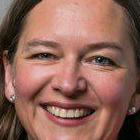

In [10]:
img_name = val_df[val_df.columns[0]].iloc[340]
img = Image.open(img_name)
img

In [12]:
# Define model
model = InceptionResnetV1(
    classify=True,
    pretrained='casia-webface',
    num_classes=1,
    dropout_prob=0.6)
weights = torch.load('/content/drive/My Drive/Colab Notebooks/model weights/facenet_cw_3conv_best.pl',map_location=torch.device('cpu'))
model.load_state_dict(weights)
if torch.cuda.is_available():
    print('using device: cuda')
else:
    print('using device: cpu')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print("done")
# print(feature_extractor)


LOADING PATH
LOADING PATH
using device: cuda
done


In [13]:
train_features = []
test_features = []
val_features = []
with torch.no_grad():
        for data in train_loader:
            device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
            inputs, label = data
            inputs = inputs.to(device)
            l25, l27, l29 = model(inputs)
            m = nn.MaxPool2d(3, stride=1)
            l29 = m(l29)
            l27 = m(l27)
            l25 = m(l25)
            train_features.append([l25.cpu().numpy(),l27.cpu().numpy(),l29.cpu().numpy(), label])
print("HALFWAY")      
with torch.no_grad():
        for data in test_loader:
            device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
            inputs, label = data
            inputs = inputs.to(device)
            l25, l27, l29 = model(inputs)
            m = nn.MaxPool2d(3, stride=1)
            l29 = m(l29)
            l27 = m(l27)
            l25 = m(l25)
            test_features.append([l25.cpu().numpy(),l27.cpu().numpy(),l29.cpu().numpy(), label])
with torch.no_grad():
        for data in val_loader:
            device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
            inputs, label = data
            inputs = inputs.to(device)
            l25, l27, l29 = model(inputs)
            m = nn.MaxPool2d(3, stride=1)
            l29 = m(l29)
            l27 = m(l27)
            l25 = m(l25)
            val_features.append([l25.cpu().numpy(),l27.cpu().numpy(),l29.cpu().numpy(), label])
            


HALFWAY


In [14]:
train_features = pd.DataFrame(train_features)
train_features.to_pickle('/content/drive/My Drive/Colab Notebooks/inception_resnet_casia-webface_features_train.pl')
test_features = pd.DataFrame(test_features)
test_features.to_pickle('/content/drive/My Drive/Colab Notebooks/inception_resnet_casia-webface_features_test.pl')
val_features = pd.DataFrame(val_features)
val_features.to_pickle('/content/drive/My Drive/Colab Notebooks/inception_resnet_casia-webface_features_val.pl')

/usr/local/lib/python3.6/dist-packages/torch/storage.py:34: FutureWarning: pickle support for Storage will be removed in 1.5. Use `torch.save` instead
  warnings.warn("pickle support for Storage will be removed in 1.5. Use `torch.save` instead", FutureWarning)


In [ ]:
test_features


,0,1,2,3
0,"[[[[2.3140001]], [[1.5412081]], [[0.737196]], ...","[[[[2.4516404]], [[1.2203344]], [[0.30334365]]...","[[[[3.1949852]], [[2.5360885]], [[0.4664612]],...","[tensor(1., dtype=torch.float64)]"
1,"[[[[0.71341693]], [[0.904728]], [[1.5660833]],...","[[[[0.8091608]], [[0.]], [[1.1402718]], [[1.30...","[[[[1.7187567]], [[1.4734917]], [[1.1626595]],...","[tensor(1., dtype=torch.float64)]"
2,"[[[[1.384095]], [[1.1293712]], [[1.5598383]], ...","[[[[1.518551]], [[0.8259967]], [[0.9435497]], ...","[[[[2.3586261]], [[2.2502615]], [[0.86222935]]...","[tensor(0., dtype=torch.float64)]"
3,"[[[[1.2499756]], [[1.2602333]], [[1.1880543]],...","[[[[1.4331722]], [[0.9731714]], [[0.36982387]]...","[[[[2.3191829]], [[2.311875]], [[0.3136097]], ...","[tensor(1., dtype=torch.float64)]"
4,"[[[[1.0103073]], [[1.3460666]], [[1.15148]], [...","[[[[0.7488626]], [[1.063228]], [[0.8082045]], ...","[[[[1.473326]], [[2.4532342]], [[0.76258934]],...","[tensor(1., dtype=torch.float64)]"
...,...,...,...,...
1073,"[[[[2.2214985]], [[0.88087624]], [[0.71161324]...","[[[[2.3936055]], [[0.5849823]], [[0.32002988]]...","[[[[3.3321648]], [[1.9509095]], [[0.41940933]]...","[tensor(1., dtype=torch.float64)]"
1074,"[[[[0.6900522]], [[1.4464544]], [[1.2762337]],...","[[[[0.9086539]], [[0.71500504]], [[0.7453298]]...","[[[[1.9180107]], [[2.4149203]], [[0.66936547]]...","[tensor(1., dtype=torch.float64)]"
1075,"[[[[0.82782793]], [[1.00612]], [[0.4278813]], ...","[[[[0.94256926]], [[0.5864259]], [[0.]], [[1.1...","[[[[1.2479162]], [[1.0745354]], [[0.02383482]]...","[tensor(1., dtype=torch.float64)]"
1076,"[[[[1.8274088]], [[1.0326741]], [[0.65776217]]...","[[[[1.6640538]], [[0.47458145]], [[0.09630744]...","[[[[1.6128714]], [[1.0961742]], [[0.08368111]]...","[tensor(1., dtype=torch.float64)]"
